# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [68]:
# import libraries

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count, when, isnull, collect_list

import datetime

from pyspark.sql import Window
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import re
from pyspark.sql import functions as sF
from pyspark.sql import types as sT
import seaborn as sns
from functools import reduce

In [69]:
# create a Spark session
from pyspark.sql import SparkSession

In [70]:
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.classification import LinearSVC, NaiveBayes,RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StopWordsRemover, StringIndexer, VectorAssembler


In [71]:
from pyspark.ml.tuning import CrossValidatorModel as mlm

spark = SparkSession.builder.appName('pandasToSparkDF').getOrCreate()


In [72]:
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [73]:
#load data
data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)
# See the data columns
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [74]:
print((df.count(), len(df.columns)))

(286500, 18)


In [75]:
#drop NA
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [76]:
#clean empty users
df = df.filter(df.userId!="")
df.count()

278154

In [77]:
# add time 
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts))
df

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, time: string]

In [78]:
# inspect 'userId' column
df.select('userId').dropDuplicates().sort('userId').show(5)
# drop empty strings
df= df.filter(df['userId'] != '')

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
+------+
only showing top 5 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [79]:
#dataframe head
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='2018-10-01 00:01:57')

In [80]:
#Define churn

In [81]:
#Create downgrade label
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df= df.withColumn("downgrade_event", flag_downgrade_event("page"))

# label downgraded users
windowval = Window.partitionBy('userId')
df = df.withColumn('downgrade', max('downgrade_event').over(windowval))

# create the churn label
flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn_event', flag_churn_event('page'))

# label churned users  
windowval = Window.partitionBy('userId')
df= df.withColumn('churn', max('churn_event').over(windowval))

In [82]:
df.select(['userId', 'churn', 'downgrade']).dropDuplicates().show(20)

+------+-----+---------+
|userId|churn|downgrade|
+------+-----+---------+
|100010|    0|        0|
|200002|    0|        0|
|   125|    1|        0|
|   124|    0|        0|
|    51|    1|        0|
|     7|    0|        0|
|    15|    0|        0|
|    54|    1|        1|
|   155|    0|        0|
|100014|    1|        0|
|   132|    0|        0|
|   154|    0|        0|
|   101|    1|        0|
|    11|    0|        1|
|   138|    0|        0|
|300017|    0|        0|
|100021|    1|        0|
|    29|    1|        0|
|    69|    0|        0|
|   112|    0|        0|
+------+-----+---------+
only showing top 20 rows



In [83]:
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [84]:
df.head(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', time='2018-10-08 12:58:54', downgrade_event=0, downgrade=0, churn_event=0, churn=0)]

In [85]:
#Customer lifetime statistics¶
lifetime = df.where('page == "NextSong" OR page == "Thumbs Up"').groupby(['userId', 'churn', 'gender', 'page']).count().toPandas()
lifetime = lifetime.pivot_table(index=['userId','churn','gender'], values='count', columns='page').reset_index()

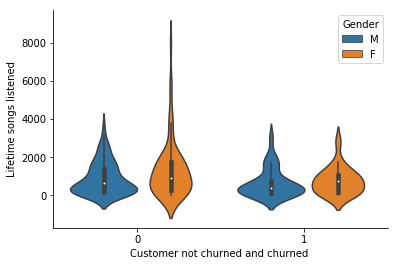

In [86]:
#violin plot for lifetime 
ax = sns.violinplot(data=lifetime, x='churn', y='NextSong', hue='gender')
plt.xlabel('Customer not churned and churned ')
plt.ylabel('Lifetime songs listened')
plt.legend(title='Gender', loc='best')
sns.despine(ax=ax);
#lifetime songs changed for customers who didn't churn

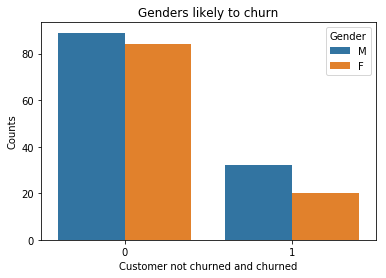

In [19]:
#Bar plot for genders likely to churn
churnbygender= df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
ax = sns.barplot(x='churn', y='count', hue='gender', data=churnbygender)
plt.title('Genders likely to churn')
plt.xlabel('Customer not churned and churned')
plt.ylabel('Counts')
plt.legend(title='Gender', loc='best')
#Males are more likely to churn than females

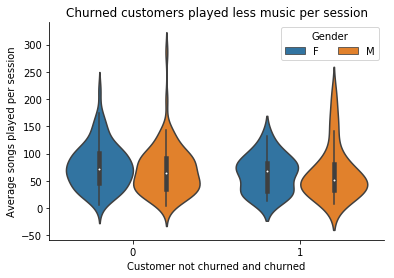

In [88]:
# violin plot time since registration
lt= df.select('userId','registration','ts','churn').withColumn('lifetime',(df.ts-df.registration)).groupBy('userId','churn') \
    .agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lifetime').select('userId', 'churn', (col('lifetime')/1000/3600/24).alias('lifetime')) \
    .toPandas()

songspergender = df.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId','gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avg_songs_played')\
    .toPandas()

ax = sns.violinplot('churn', y='avg_songs_played', hue='gender', data=songspergender)
plt.xlabel('Customer not churned and churned')
plt.ylabel('Average songs played per session')
plt.legend(title='Gender', loc='best', ncol=2)
sns.despine(ax=ax);

In [89]:
#Time since registration
Timeregistration = df.select('userId','registration','ts').withColumn('lifetime',(df.ts-df.registration)).groupBy('userId') \
    .agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lifetime').select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
Timeregistration.describe().show()

+-------+------------------+-------------------+
|summary|            userId|           lifetime|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [90]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- downgrade_event: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- churn_event: integer (nullable = true)
 |-- churn: integer (nullable = true)



In [91]:
# Feature 1 :  user gender
feature1 = df.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))

In [92]:
# Total number of  songs listened
feature2 = df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'tot_songs')

In [93]:
# Number of adds to playlist
feature3= df.select('userID','page').where(df.page == 'Add to Playlist').groupBy('userID').agg({'page':'count'}).withColumnRenamed('count(page)', 'add_to_playlist')
                                                                                                                                                                                                                                                                   

In [94]:
#number of friends added 
feature4 = df.select('userID','page').where(df.page == 'Add Friend').groupBy('userID').count().withColumnRenamed('count', 'add_friend') 
feature4.describe().show()

+-------+------------------+------------------+
|summary|            userID|        add_friend|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405007|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



In [95]:
#total length time
feature5 = df.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)', 'listen_time')
feature5.describe().show()

+-------+------------------+------------------+
|summary|            userID|       listen_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155543|
| stddev|105396.47791907164| 275396.4038847635|
|    min|                10|         691.66884|
|    max|                99|1991154.9155799907|
+-------+------------------+------------------+



In [96]:
# Average number of songs listened per session
feature6 = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'avg_songs_played')
feature6.describe().show()

+-------+------------------+-----------------+
|summary|            userId| avg_songs_played|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|70.78971233958933|
| stddev|105396.47791907164| 42.6153697543817|
|    min|                10|              3.0|
|    max|                99|286.6666666666667|
+-------+------------------+-----------------+



In [97]:
#Total number of artists the user has listened to
feature7 = df.filter(df.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count().withColumnRenamed("count", "tot_artist_played")
feature7.describe().show()

+-------+------------------+-----------------+
|summary|            userId|tot_artist_played|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|696.3777777777777|
| stddev|105396.47791907164|603.9518698630802|
|    min|                10|                3|
|    max|                99|             3544|
+-------+------------------+-----------------+



In [98]:
#  Number of thumbs down
feature8 = df.select('userId', 'page').where(df.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'tot_thumbs_down')
feature8.show()

+------+---------------+
|userId|tot_thumbs_down|
+------+---------------+
|100010|              5|
|200002|              6|
|    51|             21|
|   124|             41|
|     7|              1|
|    15|             14|
|    54|             29|
|   155|              3|
|   132|             17|
|100014|              3|
|   101|             16|
|    11|              9|
|   138|             24|
|300017|             28|
|    29|             22|
|    69|              9|
|100021|              5|
|    42|             25|
|   112|              3|
|    73|              7|
+------+---------------+
only showing top 20 rows



In [99]:
#Total number of artists the user has listened to
feature9 =  df.select("userId", col("churn").cast("int").alias("churn_label")).dropDuplicates()
feature9.show()

+------+-----------+
|userId|churn_label|
+------+-----------+
|100010|          0|
|200002|          0|
|   125|          1|
|   124|          0|
|    51|          1|
|     7|          0|
|    15|          0|
|    54|          1|
|   155|          0|
|100014|          1|
|   132|          0|
|   154|          0|
|   101|          1|
|    11|          0|
|   138|          0|
|300017|          0|
|100021|          1|
|    29|          1|
|    69|          0|
|   112|          0|
+------+-----------+
only showing top 20 rows



In [100]:
#Merge all the features
final_data = feature1.join(feature2, 'userId', 'inner').join(feature3, 'userId', 'inner').join(feature4, 'userId', 'inner')\
             .join(feature5, 'userId', 'inner').join(feature6, 'userId', 'inner').join(feature7, 'userId', 'inner')\
             .join(feature8, 'userId', 'inner').join(feature9, 'userId', 'inner')



In [101]:
#show head of final data
final_data.show(5)

+------+------+---------+---------------+----------+------------------+------------------+-----------------+---------------+-----------+
|userId|gender|tot_songs|add_to_playlist|add_friend|       listen_time|  avg_songs_played|tot_artist_played|tot_thumbs_down|churn_label|
+------+------+---------+---------------+----------+------------------+------------------+-----------------+---------------+-----------+
|100010|     0|      381|              7|         4| 66940.89735000003|39.285714285714285|              252|              5|          0|
|200002|     1|      474|              8|         4| 94008.87593999993|              64.5|              339|              6|          0|
|   124|     0|     4825|            118|        74|1012312.0927899999|145.67857142857142|             2232|             41|          0|
|    51|     1|     2464|             52|        28| 523275.8428000004|             211.1|             1385|             21|          1|
|     7|     1|      201|              5|

In [102]:
#dataframe for modeling sorted by userID
df_model = final_data.sort("userId")

In [103]:
#Show model dataframe
df_model.show(5)

+------+------+---------+---------------+----------+------------------+------------------+-----------------+---------------+-----------+
|userId|gender|tot_songs|add_to_playlist|add_friend|       listen_time|  avg_songs_played|tot_artist_played|tot_thumbs_down|churn_label|
+------+------+---------+---------------+----------+------------------+------------------+-----------------+---------------+-----------+
|    10|     1|      795|              9|        12|166866.37251000004|112.16666666666667|              565|              4|          0|
|   100|     1|     3214|             61|        49|  672877.856590001| 78.88235294117646|             1705|             27|          0|
|100001|     0|      187|              3|         2|35073.742150000005|             33.25|              125|              2|          1|
|100004|     0|     1245|             23|        19|231480.38928999988|              47.1|              733|             11|          0|
|100005|     1|      216|              3|

In [104]:
#saving the data to csv file
file = "data.csv"
df_model.write.save(file, format="csv", header=True, mode='overwrite')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [105]:
#model columns 
df_model.columns

['userId',
 'gender',
 'tot_songs',
 'add_to_playlist',
 'add_friend',
 'listen_time',
 'avg_songs_played',
 'tot_artist_played',
 'tot_thumbs_down',
 'churn_label']

In [106]:
#Assemble input features 
inputcol = ['gender', 'tot_songs', 'add_to_playlist', 'add_friend', 'listen_time','avg_songs_played','tot_thumbs_down']
assmblr = VectorAssembler(inputcol = inputcol, outputCol = "VectFeatures")
final_data = assmblr.transform(final_data)
final_data.show()

+------+------+---------+---------------+----------+------------------+------------------+-----------------+---------------+-----------+--------------------+
|userId|gender|tot_songs|add_to_playlist|add_friend|       listen_time|  avg_songs_played|tot_artist_played|tot_thumbs_down|churn_label|        VectFeatures|
+------+------+---------+---------------+----------+------------------+------------------+-----------------+---------------+-----------+--------------------+
|100010|     0|      381|              7|         4| 66940.89735000003|39.285714285714285|              252|              5|          0|[0.0,381.0,7.0,4....|
|200002|     1|      474|              8|         4| 94008.87593999993|              64.5|              339|              6|          0|[1.0,474.0,8.0,4....|
|   124|     0|     4825|            118|        74|1012312.0927899999|145.67857142857142|             2232|             41|          0|[0.0,4825.0,118.0...|
|    51|     1|     2464|             52|        28|

In [107]:
#Standardize input features to avoid weightage 
scaler = StandardScaler(inputCol = 'VectFeatures', outputCol = "newFeatures", withStd = True)
scaler_model = scaler.fit(final_data)
final_data = scaler_model.transform(final_data)

In [108]:
#final data
data = final_data.select(final_data.churn_label.alias("label"), final_data.newFeatures.alias("features"))

In [109]:
#show final data
data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.0,0.2830343354...|
|    0|[1.99749598442950...|
|    0|[0.0,3.5843587095...|
|    1|[1.99749598442950...|
|    0|[1.99749598442950...|
|    0|[1.99749598442950...|
|    1|[0.0,2.5532519968...|
|    0|[0.0,0.7443580159...|
|    1|[1.99749598442950...|
|    0|[0.0,1.7115777133...|
|    1|[1.99749598442950...|
|    0|[0.0,0.6299556861...|
|    0|[1.99749598442950...|
|    0|[0.0,3.2894384178...|
|    1|[1.99749598442950...|
|    1|[1.99749598442950...|
|    0|[0.0,0.9969345882...|
|    0|[1.99749598442950...|
|    0|[0.0,3.1624072594...|
|    1|[0.0,0.3394926280...|
+-----+--------------------+
only showing top 20 rows



In [116]:
#train and validation set
train, val = data.randomSplit([0.85, 0.15], seed = 42)
train = train.cache()

In [117]:
# Model 1: Support Vector Machine
svm_clf = LinearSVC(maxIter = 15)
f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()
cross_valid_svm = CrossValidator(estimator = svm_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [118]:
# Support Vector Machine model cross validation
cv_model_svm = cross_val_svm.fit(train)
cv_model_svm.avgMetrics

[0.7045125857666148]

In [120]:
#Results Support Vector Machine model cross validation
results_svm = cv_model_svm.transform(val)

In [121]:
#Evaluate the model using F1 and accuracy
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The F-1 Score is {}".format(evaluator.evaluate(results_svm, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(results_svm, {evaluator.metricName : "f1"})))

The F-1 Score is 0.6956521739130435
The accuracy is 0.5707915273132664


In [133]:
#Model 2: Random Forest Classifier
rand_forest_clf = RandomForestClassifier()
f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()
cross_val_rf = CrossValidator(estimator = rand_forest_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [141]:
#Random Forest Classifier cross validation
cv_model_rf = cross_val_rf.fit(train)
cv_model_rf.avgMetrics

[0.6871476632785609]

In [142]:
#Results Random Forest Classifier crossvalidation 
results_rand_forest = cv_model_rf.transform(val)

In [143]:
#Evaluation metrics for Random Forest Classifier
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The F-1 Score is {}".format(evaluator.evaluate(results_rand_forest, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(results_rand_forest, {evaluator.metricName : "f1"})))

The F-1 Score is 0.7391304347826086
The accuracy is 0.6618993135011442


In [144]:
#Gradient Boosted Trees 
G_B_T = GBTClassifier(maxIter = 10, maxDepth = 10, seed = 42)
f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()
cross_val_gbt = CrossValidator(estimator = G_B_T, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [145]:
#Gradient Boosted Trees cross validation
cv_model_gbt = cross_val_gbt.fit(train)
cv_model_gbt.avgMetrics

[0.6974126183697039]

In [139]:
#Results Gradient Boosted Trees cross validation
results_gbt = cv_model_gbt.transform(val)

In [140]:
#Evaluation Gradient Boosted Trees cross validation
Evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The F-1 Score is {}".format(evaluator.evaluate(results_gbt, {evaluator.metricName : "accuracy"})))
print("The accuracy is {}".format(evaluator.evaluate(results_gbt, {evaluator.metricName : "f1"})))

The F-1 Score is 0.6521739130434783
The accuracy is 0.6521739130434783


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.